In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [8]:
import statistics
from lifelines import KaplanMeierFitter, CoxPHFitter
from lifelines.statistics import logrank_test
from scipy import stats

import chart_studio.plotly as py
import plotly.tools as tls
from plotly.graph_objs import *


In [9]:
data = pd.read_csv('PCC.individual.project.data.csv')

In [11]:
test_data = pd.read_csv('PCC.testing.data.csv')

In [12]:
def get_risk(patient):
    if patient.death == 1 and patient.time < 365:
        # Patient is high risk
        return 1
    elif patient.death == 0 and patient.time > 730:
        # Patient is low risk
        return 0
    else:
        # Patient needs to be dropped, insufficient data
        return 'drop'


In [13]:
data['high_risk'] = data.apply(get_risk, axis=1)
data = data.loc[lambda patient: patient.high_risk != 'drop']

In [14]:
data = data.drop(['time','death'],axis=1)

In [23]:
test_data = test_data.drop(['time', 'death'], axis=1)


In [15]:
data = data.drop(['STUDYID','RPT'],axis=1)

In [16]:
test_data = test_data.drop(['STUDYID', 'RPT'], axis=1)


In [19]:
X = data.drop(['high_risk'], axis=1).values
y = data['high_risk'].values


In [20]:
y = y.astype('int')


In [13]:
from sklearn.model_selection import train_test_split


In [16]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=101)


# Support Vector Machine

In [16]:
from sklearn.svm import SVC


## First Attempt w/ Regular Params

In [14]:
model = SVC()

In [19]:
model.fit(X_train,y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [20]:
predictions = model.predict(X_test)

In [24]:
from sklearn.metrics import classification_report, confusion_matrix


In [22]:
print(confusion_matrix(y_test, predictions))


[[ 0 54]
 [ 0 96]]


In [23]:
print(classification_report(y_test, predictions))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00        54
           1       0.64      1.00      0.78        96

    accuracy                           0.64       150
   macro avg       0.32      0.50      0.39       150
weighted avg       0.41      0.64      0.50       150



/Users/belalelsiesy/opt/anaconda3/envs/DataViz/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Second Try: w/ Best Params

In [24]:
param_grid = {'C': [0.1, 1, 10, 100, 1000], 'gamma': [
    1, 0.1, 0.01, 0.001, 0.0001], 'kernel': ['rbf']}


In [25]:
from sklearn.model_selection import GridSearchCV


In [26]:
grid = GridSearchCV(SVC(), param_grid, refit=True, verbose=3)

In [27]:
grid.fit(X_train, y_train)

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] .......... C=0.1, gamma=1, kernel=rbf, score=0.623, total=   0.0s
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] .......... C=0.1, gamma=1, kernel=rbf, score=0.623, total=   0.0s
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] .......... C=0.1, gamma=1, kernel=rbf, score=0.639, total=   0.0s
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] .......... C=0.1, gamma=1, kernel=rbf, score=0.633, total=   0.0s
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] .......... C=0.1, gamma=1, kernel=rbf, score=0.633, total=   0.0s
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV] ........ C=0.1, gamma=0.1, kernel=rbf, score=0.623, total=   0.0s
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV] ........ C

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


[CV] ...... C=0.1, gamma=0.001, kernel=rbf, score=0.623, total=   0.0s
[CV] C=0.1, gamma=0.001, kernel=rbf ..................................
[CV] ...... C=0.1, gamma=0.001, kernel=rbf, score=0.623, total=   0.0s
[CV] C=0.1, gamma=0.001, kernel=rbf ..................................
[CV] ...... C=0.1, gamma=0.001, kernel=rbf, score=0.639, total=   0.0s
[CV] C=0.1, gamma=0.001, kernel=rbf ..................................
[CV] ...... C=0.1, gamma=0.001, kernel=rbf, score=0.633, total=   0.0s
[CV] C=0.1, gamma=0.001, kernel=rbf ..................................
[CV] ...... C=0.1, gamma=0.001, kernel=rbf, score=0.633, total=   0.0s
[CV] C=0.1, gamma=0.0001, kernel=rbf .................................
[CV] ..... C=0.1, gamma=0.0001, kernel=rbf, score=0.623, total=   0.0s
[CV] C=0.1, gamma=0.0001, kernel=rbf .................................
[CV] ..... C=0.1, gamma=0.0001, kernel=rbf, score=0.623, total=   0.0s
[CV] C=0.1, gamma=0.0001, kernel=rbf .................................
[CV] .

[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:    1.8s finished


GridSearchCV(cv=None, error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [0.1, 1, 10, 100, 1000],
                         'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                         'kernel': ['rbf']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=3)

In [28]:
grid.best_params_

{'C': 10, 'gamma': 0.0001, 'kernel': 'rbf'}

In [29]:
grid.best_estimator_

SVC(C=10, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.0001, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [30]:
grid_predictions = grid.predict(X_test)

In [31]:
print(confusion_matrix(y_test, grid_predictions))
print('\n')
print(classification_report(y_test, grid_predictions))

[[21 33]
 [16 80]]


              precision    recall  f1-score   support

           0       0.57      0.39      0.46        54
           1       0.71      0.83      0.77        96

    accuracy                           0.67       150
   macro avg       0.64      0.61      0.61       150
weighted avg       0.66      0.67      0.66       150



# Logistic Regression Model

In [24]:
from sklearn.linear_model import LogisticRegression

In [35]:
logModel = LogisticRegression(solver='liblinear')

In [36]:
logModel.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [37]:
log_predictions = logModel.predict(X_test)


In [38]:
print(classification_report(y_test, log_predictions))
print('\n')
print(confusion_matrix(y_test, log_predictions))

              precision    recall  f1-score   support

           0       0.67      0.70      0.68        54
           1       0.83      0.80      0.81        96

    accuracy                           0.77       150
   macro avg       0.75      0.75      0.75       150
weighted avg       0.77      0.77      0.77       150



[[38 16]
 [19 77]]


# Random Forest Classifier

In [17]:
from sklearn.ensemble import RandomForestClassifier

In [28]:
rfc = RandomForestClassifier(n_estimators=100)
rfc.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [29]:
rfc_pred = rfc.predict(X_test)

In [30]:
print(classification_report(y_test, rfc_pred))
print('\n')
print(confusion_matrix(y_test, rfc_pred))


              precision    recall  f1-score   support

           0       0.79      0.70      0.75        54
           1       0.84      0.90      0.87        96

    accuracy                           0.83       150
   macro avg       0.82      0.80      0.81       150
weighted avg       0.82      0.83      0.82       150



[[38 16]
 [10 86]]


In [43]:
rfc2 = RandomForestClassifier(n_estimators=300)
rfc2.fit(X_train, y_train)


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [44]:
rfc2_pred = rfc2.predict(X_test)

In [46]:
print(classification_report(y_test, rfc2_pred))
print('\n')
print(confusion_matrix(y_test, rfc2_pred))


              precision    recall  f1-score   support

           0       0.83      0.65      0.73        54
           1       0.82      0.93      0.87        96

    accuracy                           0.83       150
   macro avg       0.83      0.79      0.80       150
weighted avg       0.83      0.83      0.82       150



[[35 19]
 [ 7 89]]


# Cross Validations

In [2]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score

In [21]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
encoder.fit(y)
encoded_Y = encoder.transform(y)


In [3]:
kfold = StratifiedKFold(n_splits=10, shuffle=True)

## Support Vector Machine

In [20]:
results = cross_val_score(SVC(), X, encoded_Y, cv=kfold)
print("Baseline: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

Baseline: 63.36% (0.94%)


### Best params

In [22]:
results = cross_val_score(SVC(C=10, gamma=0.0001), X, encoded_Y, cv=kfold)
print("Baseline: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))


Baseline: 71.31% (3.51%)


## Logistic Regression

In [26]:
results = cross_val_score(LogisticRegression(solver='liblinear'), X, encoded_Y, cv=kfold)
print("Baseline: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))


Baseline: 79.66% (5.41%)


## Random Forest

In [27]:
results = cross_val_score(RandomForestClassifier(n_estimators=100), X, encoded_Y, cv=kfold)
print("Baseline: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))


Baseline: 81.05% (7.44%)


In [28]:
results = cross_val_score(RandomForestClassifier(
    n_estimators=300), X, encoded_Y, cv=kfold)
print("Baseline: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))


Baseline: 81.45% (5.64%)


# Final Model

In [18]:
rfc_f = RandomForestClassifier(n_estimators=300)


In [22]:
rfc_f.fit(X, y)

RandomForestClassifier(n_estimators=300)

In [24]:
f_pred = rfc_f.predict(test_data)

In [25]:
f_pred

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1,

In [28]:
test_data['pred'] = f_pred

# Variable Importances

In [37]:
import time
import numpy as np

start_time = time.time()
importances = rfc_f.feature_importances_
std = np.std([
    tree.feature_importances_ for tree in rfc_f.estimators_], axis=0)
elapsed_time = time.time() - start_time

print(f"Elapsed time to compute the importances: "
      f"{elapsed_time:.3f} seconds")

Elapsed time to compute the importances: 0.101 seconds


Int64Index([   2,    3,    6,   16,   21,   24,   26,   30,   34,   37,
            ...
            1584, 1585, 1586, 1587, 1589, 1590, 1594, 1596, 1597, 1599],
           dtype='int64', length=453)

(101,)


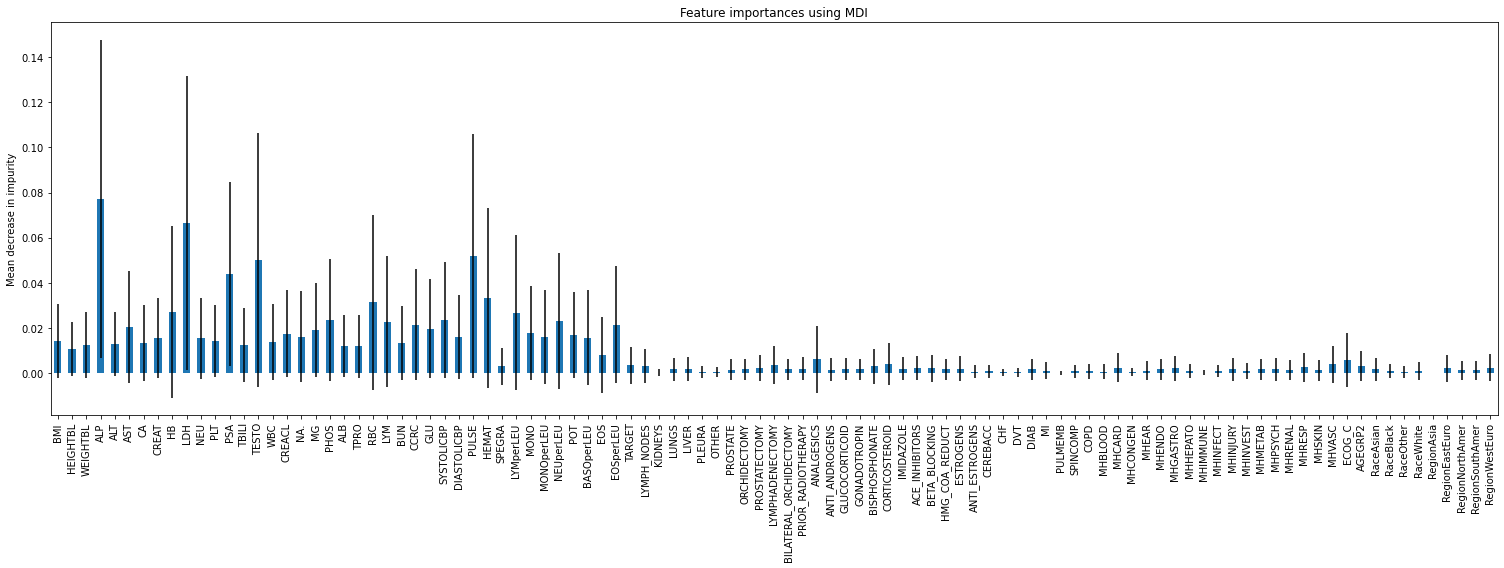

In [72]:
feature_names = data.columns.drop('high_risk')
print(feature_names.shape)
forest_importances = pd.Series(importances, index=feature_names)

fig, ax = plt.subplots(figsize=(21,8))
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()


In [74]:
from sklearn.inspection import permutation_importance

start_time = time.time()
result = permutation_importance(
    rfc_f, X, y, n_repeats=10, random_state=42, n_jobs=2)
elapsed_time = time.time() - start_time
print(f"Elapsed time to compute the importances: "
      f"{elapsed_time:.3f} seconds")

forest_importances = pd.Series(result.importances_mean, index=feature_names)


Elapsed time to compute the importances: 29.295 seconds


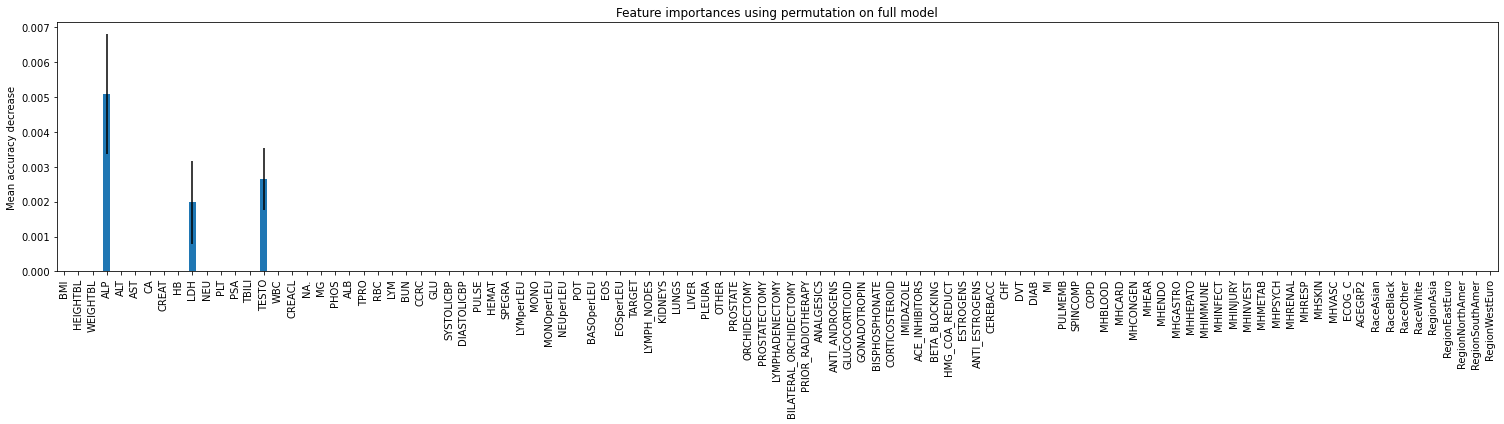

In [75]:
fig, ax = plt.subplots(figsize=(21,6))
forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()


In [34]:
low_risk = test_data.loc[test_data['pred'] == 0]
high_risk = test_data.loc[test_data['pred'] == 1]

In [27]:
kmf = KaplanMeierFitter()

In [36]:
# T = low_risk['time']
# C = low_risk['pred']

# T2 = high_risk['time']
# C2 = high_risk['pred']

# ax = plt.subplot(111)

# kmf.fit(T, event_observed=C, label=['Low Risk Group'])
# kmf.survival_function_.plot(ax=ax)
# kmf.fit(T2, event_observed=C2, label=['High Risk Group'])
# kmf.survival_function_.plot(ax=ax)

# plt.title('Predicted Survival')

# kmf2 = plt.gcf()
